In this file I will make regres model.

In [79]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv('CNN_mod.csv')
X = df.drop(['w_time', 'Unnamed: 0'], axis=1).copy()
y = df['w_time']

In [30]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4)

In [31]:
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

For making decision I need to iterate all regressors from scikit-learn. So let's do this.

In [68]:
from tqdm import tqdm
import datetime
import time
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
)
import warnings
import xgboost

# import catboost
import lightgbm

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: "%.2f" % x)



removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor", 
]

CLASSIFIERS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], ClassifierMixin) and (est[0] not in removed_classifiers))
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]

REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
# REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))


numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer_low = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

categorical_transformer_high = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
        ("encoding", OrdinalEncoder()),
    ]
)


# Helper function


def get_card_split(df, cols, n=11):
    """
    Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame from which the cardinality of the columns is calculated.
    cols : list-like
        Categorical columns to list
    n : int, optional (default=11)
        The value of 'n' will be used to split columns.
    Returns
    -------
    card_low : list-like
        Columns with cardinality < n
    card_high : list-like
        Columns with cardinality >= n
    """
    cond = df[cols].nunique() > n
    card_high = cols[cond]
    card_low = cols[~cond]
    return card_low, card_high


In [69]:

class LazyRegressor:
    """
    This module helps in fitting regression models that are available in Scikit-learn
    Parameters
    ----------
    verbose : int, optional (default=0)
        For the liblinear and lbfgs solvers set verbose to any positive
        number for verbosity.
    ignore_warnings : bool, optional (default=True)
        When set to True, the warning related to algorigms that are not able to run are ignored.
    custom_metric : function, optional (default=None)
        When function is provided, models are evaluated based on the custom evaluation metric provided.
    prediction : bool, optional (default=False)
        When set to True, the predictions of all the models models are returned as dataframe.
    regressors : list, optional (default="all")
        When function is provided, trains the chosen regressor(s).
    Examples
    --------
    >>> from lazypredict.Supervised import LazyRegressor
    >>> from sklearn import datasets
    >>> from sklearn.utils import shuffle
    >>> import numpy as np
    >>> boston = datasets.load_boston()
    >>> X, y = shuffle(boston.data, boston.target, random_state=13)
    >>> X = X.astype(np.float32)
    >>> offset = int(X.shape[0] * 0.9)
    >>> X_train, y_train = X[:offset], y[:offset]
    >>> X_test, y_test = X[offset:], y[offset:]
    >>> reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    >>> models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    >>> model_dictionary = reg.provide_models(X_train, X_test, y_train, y_test)
    >>> models
    | Model                         | Adjusted R-Squared | R-Squared |  RMSE | Time Taken |
    |:------------------------------|-------------------:|----------:|------:|-----------:|
    | SVR                           |               0.83 |      0.88 |  2.62 |       0.01 |
    | BaggingRegressor              |               0.83 |      0.88 |  2.63 |       0.03 |
    | NuSVR                         |               0.82 |      0.86 |  2.76 |       0.03 |
    | RandomForestRegressor         |               0.81 |      0.86 |  2.78 |       0.21 |
    | XGBRegressor                  |               0.81 |      0.86 |  2.79 |       0.06 |
    | GradientBoostingRegressor     |               0.81 |      0.86 |  2.84 |       0.11 |
    | ExtraTreesRegressor           |               0.79 |      0.84 |  2.98 |       0.12 |
    | AdaBoostRegressor             |               0.78 |      0.83 |  3.04 |       0.07 |
    | HistGradientBoostingRegressor |               0.77 |      0.83 |  3.06 |       0.17 |
    | PoissonRegressor              |               0.77 |      0.83 |  3.11 |       0.01 |
    | LGBMRegressor                 |               0.77 |      0.83 |  3.11 |       0.07 |
    | KNeighborsRegressor           |               0.77 |      0.83 |  3.12 |       0.01 |
    | DecisionTreeRegressor         |               0.65 |      0.74 |  3.79 |       0.01 |
    | MLPRegressor                  |               0.65 |      0.74 |  3.80 |       1.63 |
    | HuberRegressor                |               0.64 |      0.74 |  3.84 |       0.01 |
    | GammaRegressor                |               0.64 |      0.73 |  3.88 |       0.01 |
    | LinearSVR                     |               0.62 |      0.72 |  3.96 |       0.01 |
    | RidgeCV                       |               0.62 |      0.72 |  3.97 |       0.01 |
    | BayesianRidge                 |               0.62 |      0.72 |  3.97 |       0.01 |
    | Ridge                         |               0.62 |      0.72 |  3.97 |       0.01 |
    | TransformedTargetRegressor    |               0.62 |      0.72 |  3.97 |       0.01 |
    | LinearRegression              |               0.62 |      0.72 |  3.97 |       0.01 |
    | ElasticNetCV                  |               0.62 |      0.72 |  3.98 |       0.04 |
    | LassoCV                       |               0.62 |      0.72 |  3.98 |       0.06 |
    | LassoLarsIC                   |               0.62 |      0.72 |  3.98 |       0.01 |
    | LassoLarsCV                   |               0.62 |      0.72 |  3.98 |       0.02 |
    | Lars                          |               0.61 |      0.72 |  3.99 |       0.01 |
    | LarsCV                        |               0.61 |      0.71 |  4.02 |       0.04 |
    | SGDRegressor                  |               0.60 |      0.70 |  4.07 |       0.01 |
    | TweedieRegressor              |               0.59 |      0.70 |  4.12 |       0.01 |
    | GeneralizedLinearRegressor    |               0.59 |      0.70 |  4.12 |       0.01 |
    | ElasticNet                    |               0.58 |      0.69 |  4.16 |       0.01 |
    | Lasso                         |               0.54 |      0.66 |  4.35 |       0.02 |
    | RANSACRegressor               |               0.53 |      0.65 |  4.41 |       0.04 |
    | OrthogonalMatchingPursuitCV   |               0.45 |      0.59 |  4.78 |       0.02 |
    | PassiveAggressiveRegressor    |               0.37 |      0.54 |  5.09 |       0.01 |
    | GaussianProcessRegressor      |               0.23 |      0.43 |  5.65 |       0.03 |
    | OrthogonalMatchingPursuit     |               0.16 |      0.38 |  5.89 |       0.01 |
    | ExtraTreeRegressor            |               0.08 |      0.32 |  6.17 |       0.01 |
    | DummyRegressor                |              -0.38 |     -0.02 |  7.56 |       0.01 |
    | LassoLars                     |              -0.38 |     -0.02 |  7.56 |       0.01 |
    | KernelRidge                   |             -11.50 |     -8.25 | 22.74 |       0.01 |
    """

    def __init__(
        self,
        verbose=0,
        ignore_warnings=True,
        custom_metric=None,
        predictions=False,
        random_state=42,
        regressors="all",
    ):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.models = {}
        self.random_state = random_state
        self.regressors = regressors

    def fit(self, X_train, X_test, y_train, y_test):
        """Fit Regression algorithms to X_train and y_train, predict and score on X_test, y_test.
        Parameters
        ----------
        X_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        X_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        y_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        Returns
        -------
        scores : Pandas DataFrame
            Returns metrics of all the models in a Pandas DataFrame.
        predictions : Pandas DataFrame
            Returns predictions of all the models in a Pandas DataFrame.
        """
        R2 = []
        ADJR2 = []
        RMSE = []
        # WIN = []
        names = []
        TIME = []
        predictions = {}

        if self.custom_metric:
            CUSTOM_METRIC = []

        if isinstance(X_train, np.ndarray):
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        categorical_features = X_train.select_dtypes(include=["object"]).columns

        categorical_low, categorical_high = get_card_split(
            X_train, categorical_features
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", numeric_transformer, numeric_features),
                ("categorical_low", categorical_transformer_low, categorical_low),
                ("categorical_high", categorical_transformer_high, categorical_high),
            ]
        )

        if self.regressors == "all":
            self.regressors = REGRESSORS
        else:
            try:
                temp_list = []
                for regressor in self.regressors:
                    full_name = (regressor.__name__, regressor)
                    temp_list.append(full_name)
                self.regressors = temp_list
            except Exception as exception:
                print(exception)
                print("Invalid Regressor(s)")

        for name, model in tqdm(self.regressors):
            start = time.time()
            try:
                if "random_state" in model().get_params().keys():
                    pipe = Pipeline(
                        steps=[
                            ("preprocessor", preprocessor),
                            ("regressor", model(random_state=self.random_state)),
                        ]
                    )
                else:
                    pipe = Pipeline(
                        steps=[("preprocessor", preprocessor), ("regressor", model())]
                    )

                pipe.fit(X_train, y_train)
                self.models[name] = pipe
                y_pred = pipe.predict(X_test)

                r_squared = r2_score(y_test, y_pred)
                #adj_rsquared = adjusted_rsquared(
                    #r_squared, X_test.shape[0], X_test.shape[1]
                #)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                names.append(name)
                R2.append(r_squared)
                #ADJR2.append(adj_rsquared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)

                if self.custom_metric:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)

                if self.verbose > 0:
                    scores_verbose = {
                        "Model": name,
                        "R-Squared": r_squared,
                        #"Adjusted R-Squared": adj_rsquared,
                        "RMSE": rmse,
                        "Time taken": time.time() - start,
                    }

                    if self.custom_metric:
                        scores_verbose[self.custom_metric.__name__] = custom_metric

                    print(scores_verbose)
                if self.predictions:
                    predictions[name] = y_pred
            except Exception as exception:
                if self.ignore_warnings is False:
                    print(name + " model failed to execute")
                    print(exception)

        scores = {
            "Model": names,
            #"Adjusted R-Squared": ADJR2,
            "R-Squared": R2,
            "RMSE": RMSE,
            "Time Taken": TIME,
        }

        if self.custom_metric:
            scores[self.custom_metric.__name__] = CUSTOM_METRIC

        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by="RMSE", ascending=True).set_index(
            "Model"
        )

        if self.predictions:
            predictions_df = pd.DataFrame.from_dict(predictions)
        return scores, predictions_df if self.predictions is True else scores

    def provide_models(self, X_train, X_test, y_train, y_test):
        """
        This function returns all the model objects trained in fit function.
        If fit is not called already, then we call fit and then return the models.
        Parameters
        ----------
        X_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        X_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        y_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        Returns
        -------
        models: dict-object,
            Returns a dictionary with each model pipeline as value 
            with key as name of models.
        """
        if len(self.models.keys()) == 0:
            self.fit(X_train, X_test, y_train, y_test)

        return self.models


Regression = LazyRegressor



In [70]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:03<00:00, 12.13it/s]


,R-Squared,RMSE,Time Taken
Model,,,
QuantileRegressor,-0.00,6.58,0.83
LassoLarsCV,-0.00,6.58,0.02
LassoCV,-0.00,6.58,0.11
Lasso,-0.00,6.58,0.01
LarsCV,-0.00,6.58,0.03
LassoLarsIC,-0.00,6.58,0.02
LassoLars,-0.00,6.58,0.01
ElasticNet,-0.00,6.58,0.02
ElasticNetCV,-0.00,6.58,0.16


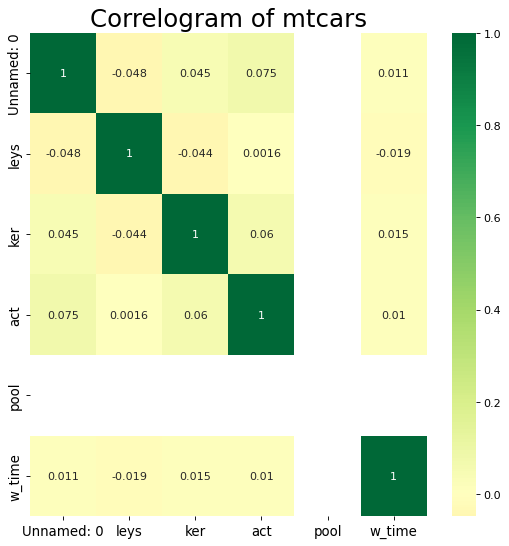

In [83]:
plt.figure(figsize=(8,8), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

How you can see upper, best models are showing R-Squared = 0, and RMSE 6,58, when target metric have spread 22. \
Max corr 0.06 \
From this result I can see what where is no bonding beetwin all metrics and target. \
So it need to find new way to do metris and target. Random doesn't work.